### Loading necessary library

In [14]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import cv2, os, pickle

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import keras
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout


### Loading Dataset

In [5]:
data = []
labels = []
cur_path = '/home/hasan/DATA SET/gtsrb-german-traffic-sign/'


for i in range(43):
    path = os.path.join(cur_path,'train/',str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(path + '/'+ a)
            image = image.resize((30,30))
            image = np.array(image)
            #sim = Image.fromarray(image)
            data.append(image)
            labels.append(i)
        except:
            print("There something error")

### Converting list into numpy array

In [6]:
data = np.array(data)
labels = np.array(labels)
print('Shape of data :',data.shape)
print('Shape of labels :',labels.shape)

Shape of data : (39209, 30, 30, 3)
Shape of labels : (39209,)


### Splitting training data into training and testing data

In [7]:
Xtrain, xvalid, Ytrain, yvalid = train_test_split(data, labels, test_size=0.2, random_state=42)
print('Shape of Xtrain :',Xtrain.shape,'\n','Shape of xvalid :', xvalid.shape,'\n',
      'Shape of Ytrain :',Ytrain.shape,'\n','Shape of yvalid :',yvalid.shape)

Shape of Xtrain : (31367, 30, 30, 3) 
 Shape of xvalid : (7842, 30, 30, 3) 
 Shape of Ytrain : (31367,) 
 Shape of yvalid : (7842,)


### Converting the labels into one hot encoding

In [8]:
Ytrain_one_hot = to_categorical(Ytrain, 43)
yvalid_one_hot = to_categorical(yvalid, 43)
print('Shape of y_train :',Ytrain_one_hot.shape)
print('Shape of y_test :',yvalid_one_hot.shape)

Shape of y_train : (31367, 43)
Shape of y_test : (7842, 43)


### Neural Network

In [9]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(30,30,3)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

In [10]:
#summary of the model
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

In [11]:
# Compile model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

### Data Normalizing

In [12]:
#for train data
train_datagen = ImageDataGenerator(  
                      rescale=1./255,
                      )
train_datagen.fit(Xtrain)

#for validation data
valid_datagen = ImageDataGenerator(                
                      rescale=1./255
                      )
valid_datagen.fit(xvalid)

### Training the model

In [15]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=2)
]

In [16]:
model_history = model.fit_generator(train_datagen.flow(Xtrain, Ytrain_one_hot,batch_size=32),
                                    steps_per_epoch=len(Xtrain)/32, epochs=10, verbose=1,
                                    validation_data=valid_datagen.flow(xvalid, yvalid_one_hot))

Epoch 1/10
981/980 [==============================] - 104s 106ms/step - loss: 1.3040 - accuracy: 0.6292 - val_loss: 0.1326 - val_accuracy: 0.9452
Epoch 2/10
981/980 [==============================] - 120s 123ms/step - loss: 0.3011 - accuracy: 0.9071 - val_loss: 0.0035 - val_accuracy: 0.9742
Epoch 3/10
981/980 [==============================] - 112s 115ms/step - loss: 0.1917 - accuracy: 0.9410 - val_loss: 0.0014 - val_accuracy: 0.9802
Epoch 4/10
981/980 [==============================] - 109s 111ms/step - loss: 0.1545 - accuracy: 0.9534 - val_loss: 0.0082 - val_accuracy: 0.9800
Epoch 5/10
981/980 [==============================] - 102s 104ms/step - loss: 0.1322 - accuracy: 0.9581 - val_loss: 0.2890 - val_accuracy: 0.9879
Epoch 6/10
981/980 [==============================] - 103s 105ms/step - loss: 0.1117 - accuracy: 0.9657 - val_loss: 6.5920e-05 - val_accuracy: 0.9883
Epoch 7/10
981/980 [==============================] - 108s 110ms/step - loss: 0.0950 - accuracy: 0.9716 - val_loss: 1.56

### Visualization of Accuracy and Loss

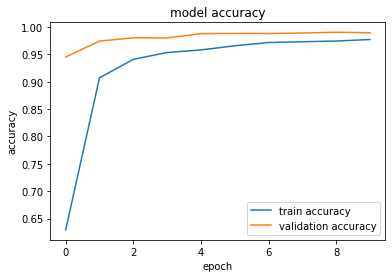

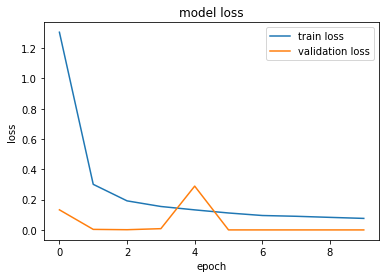

In [17]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='best')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='best')
plt.show()

### Predicting with Test Data

In [18]:
y_test = pd.read_csv('/home/hasan/DATA SET/gtsrb-german-traffic-sign/Test.csv')

In [19]:
labels = y_test["ClassId"].values
imgs = y_test["Path"].values

In [20]:
path = '/home/hasan/DATA SET/gtsrb-german-traffic-sign/'
data=[]

full_path=path+imgs

for img in imgs:
    image = Image.open(path+img)
    image = image.resize((30,30))
    data.append(np.array(image))
X_test=np.array(data)

In [21]:
pred = model.predict_classes(X_test)


In [22]:
#Accuracy with the test data
print(accuracy_score(labels, pred))

0.9536025336500396


### Classification Report

In [23]:
#printing classification report
print(classification_report(labels,pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        60
           1       0.94      0.97      0.95       720
           2       0.94      0.99      0.97       750
           3       0.95      0.96      0.95       450
           4       0.99      0.96      0.98       660
           5       0.94      0.94      0.94       630
           6       0.99      0.73      0.84       150
           7       0.98      0.97      0.98       450
           8       1.00      0.91      0.95       450
           9       0.97      0.99      0.98       480
          10       1.00      0.98      0.99       660
          11       0.98      0.88      0.93       420
          12       0.98      0.96      0.97       690
          13       0.99      0.99      0.99       720
          14       1.00      1.00      1.00       270
          15       0.95      1.00      0.97       210
          16       0.93      1.00      0.96       150
          17       0.94    

### Confusion Matrix

Text(222.00000000000003, 0.5, 'Predicted label')

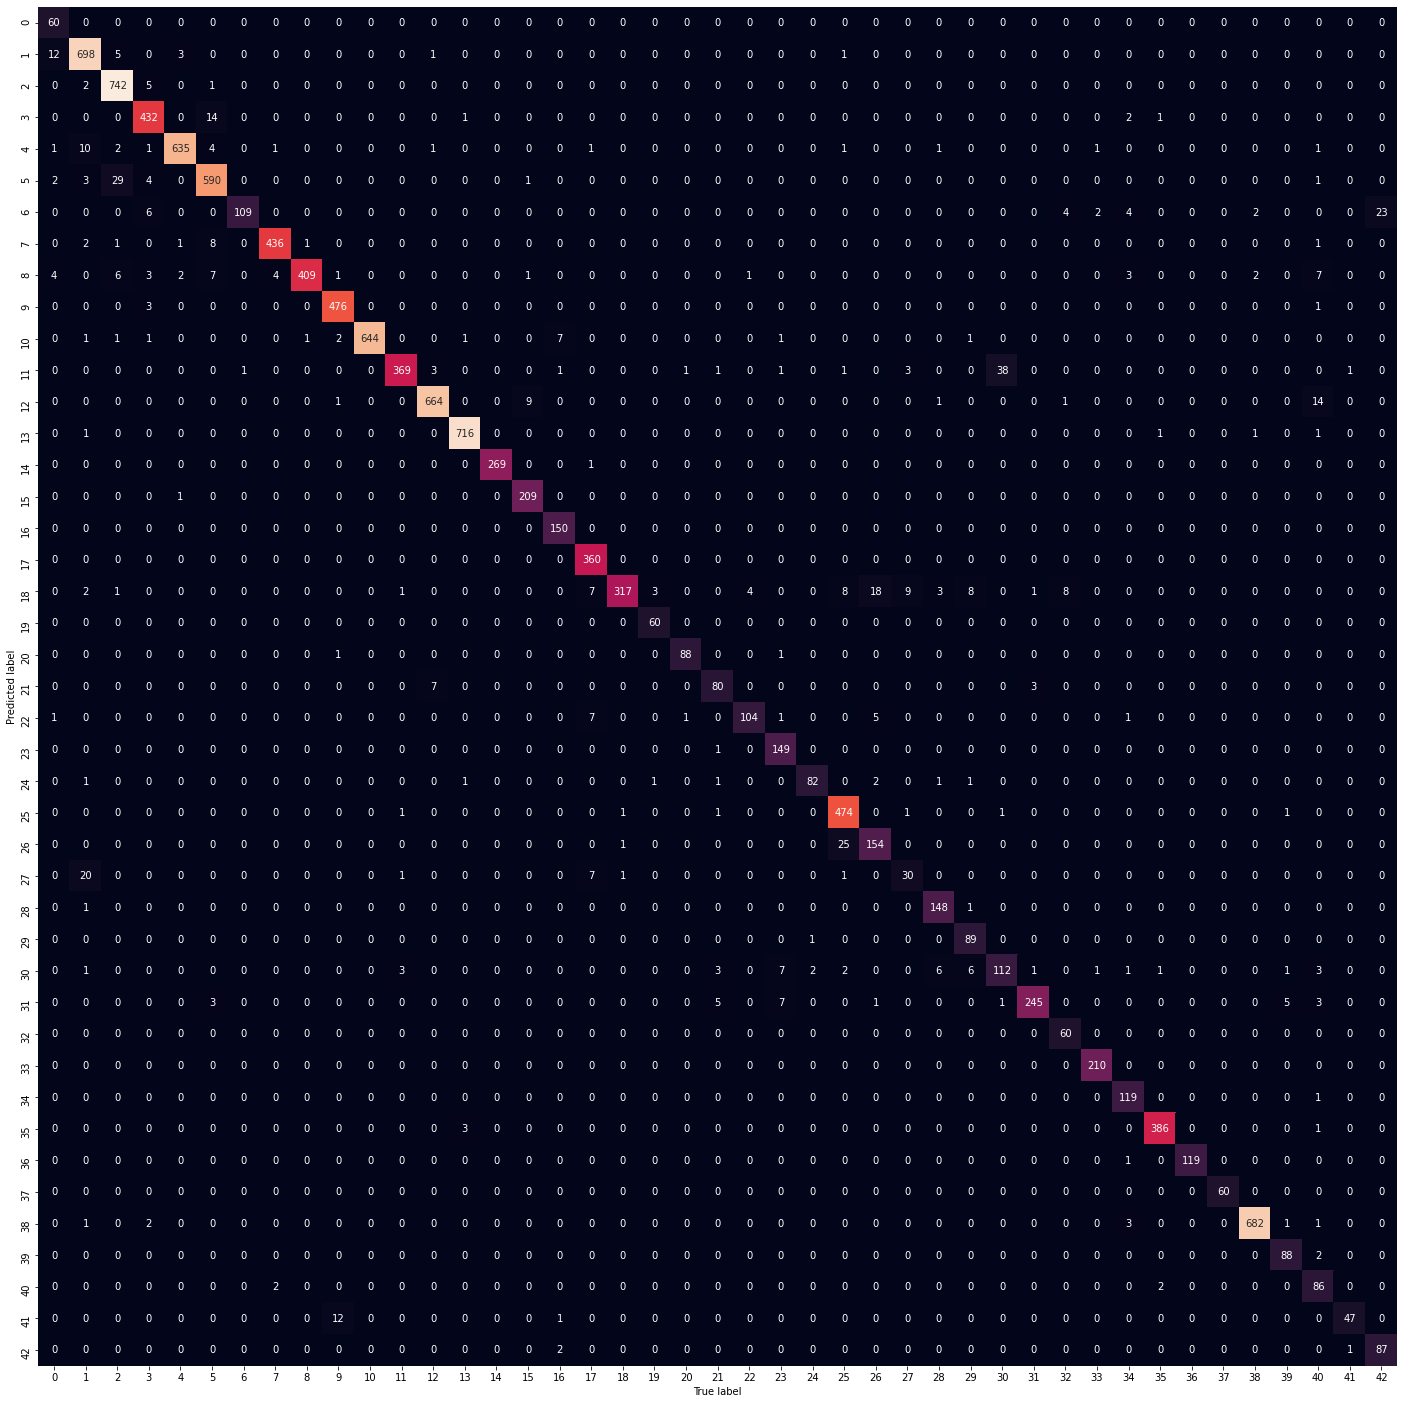

In [24]:
#printing confusion matrix
plt.figure(figsize=(25,25))
sns.heatmap(confusion_matrix(labels,pred), square=True, annot=True, cbar=False, fmt='d',)
plt.xlabel('True label')
plt.ylabel('Predicted label')

### Save Model

In [25]:
pickle_out = open("German_Traffic.p", 'wb')
pickle.dump(model, pickle_out)
pickle_out.close()